1) Load Libraries and Data

In [86]:
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

2) Data Exploration 

In [87]:
# Explore the data
print("\nInformation about the DataFrame:")
print(data.info())

print("\nSummary statistics of the DataFrame:")
print(data.describe(include='all'))

# Display the data types of each column
print("\nData types of each column:")
print(data.dtypes)


Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329443 entries, 0 to 329442
Columns: 158 entries, country to weight
dtypes: float64(105), int64(24), object(29)
memory usage: 397.1+ MB
None

Summary statistics of the DataFrame:
       country           year      msna ADM2_PCODE ADM1_PCODE  \
count   329443  329443.000000    329443     107016     116498   
unique      19            NaN        41        630        132   
top        drc            NaN  drc-2023  NER004005     NER006   
freq     53671            NaN     40790       1274       4437   
mean       NaN    2022.116645       NaN        NaN        NaN   
std        NaN       0.784639       NaN        NaN        NaN   
min        NaN    2021.000000       NaN        NaN        NaN   
25%        NaN    2021.000000       NaN        NaN        NaN   
50%        NaN    2022.000000       NaN        NaN        NaN   
75%        NaN    2023.000000       NaN        NaN        NaN   
max        NaN    2023

3) Data Cleaning and Preparation

3.1 Drop columns not needed and those with too many NAs


DataFrame before dropping variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329443 entries, 0 to 329442
Columns: 158 entries, country to weight
dtypes: float64(105), int64(24), object(29)
memory usage: 397.1+ MB
None

DataFrame after dropping specified dummy variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329443 entries, 0 to 329442
Columns: 152 entries, country to shelter_type_NA
dtypes: float64(104), int64(24), object(24)
memory usage: 382.0+ MB
None

Columns with more than 50% missing values:
['ADM2_PCODE', 'ADM1_PCODE', 'sep_children_hosting', 'separated_reason', 'displ_status_specific', 'received_assistance_3m', 'received_assistance_12m', 'wgq_dis_4_n', 'wgq_dis_3_n', 'wgq_dis_2_n', 'wgq_dis_4_at_least_one', 'wgq_dis_3_at_least_one', 'wgq_dis_2_at_least_one', 'fatalities_3m', 'events_3m', 'fatalities_6m', 'events_6m', 'fatalities_1y', 'events_1y', 'sep_children_hosting_no', 'sep_children_hosting_yes', 'separated_reason_dont_know', 'separated_reason_employm

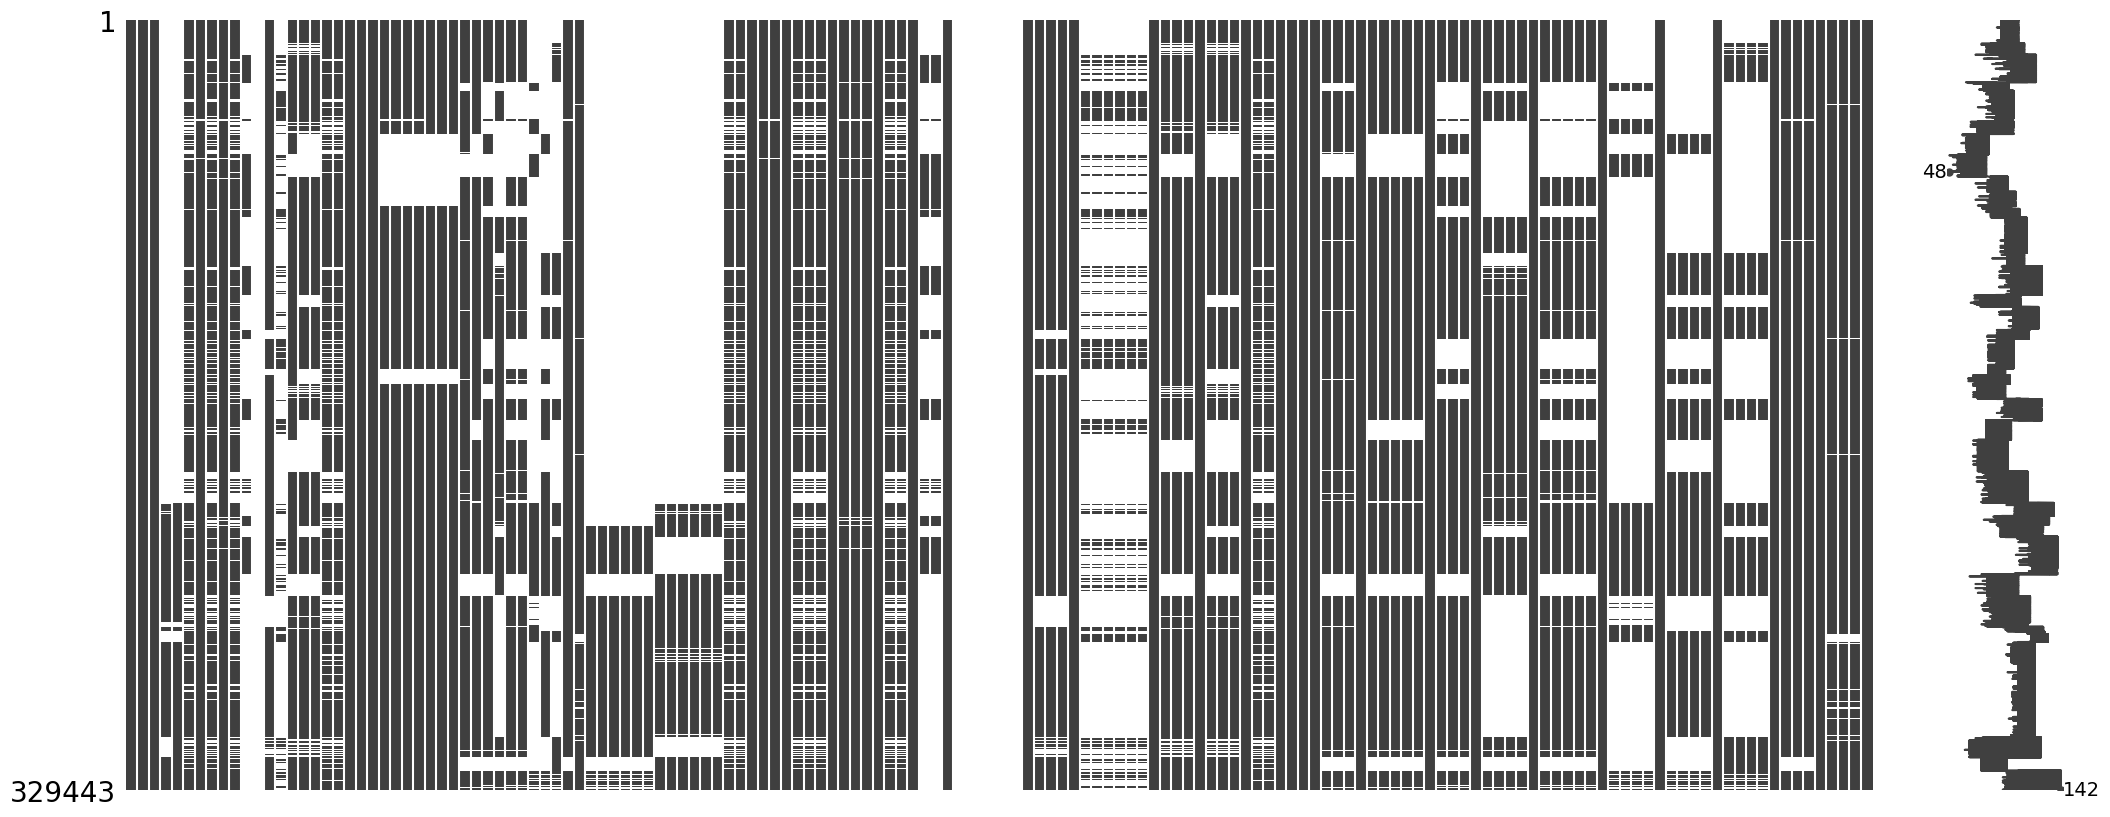

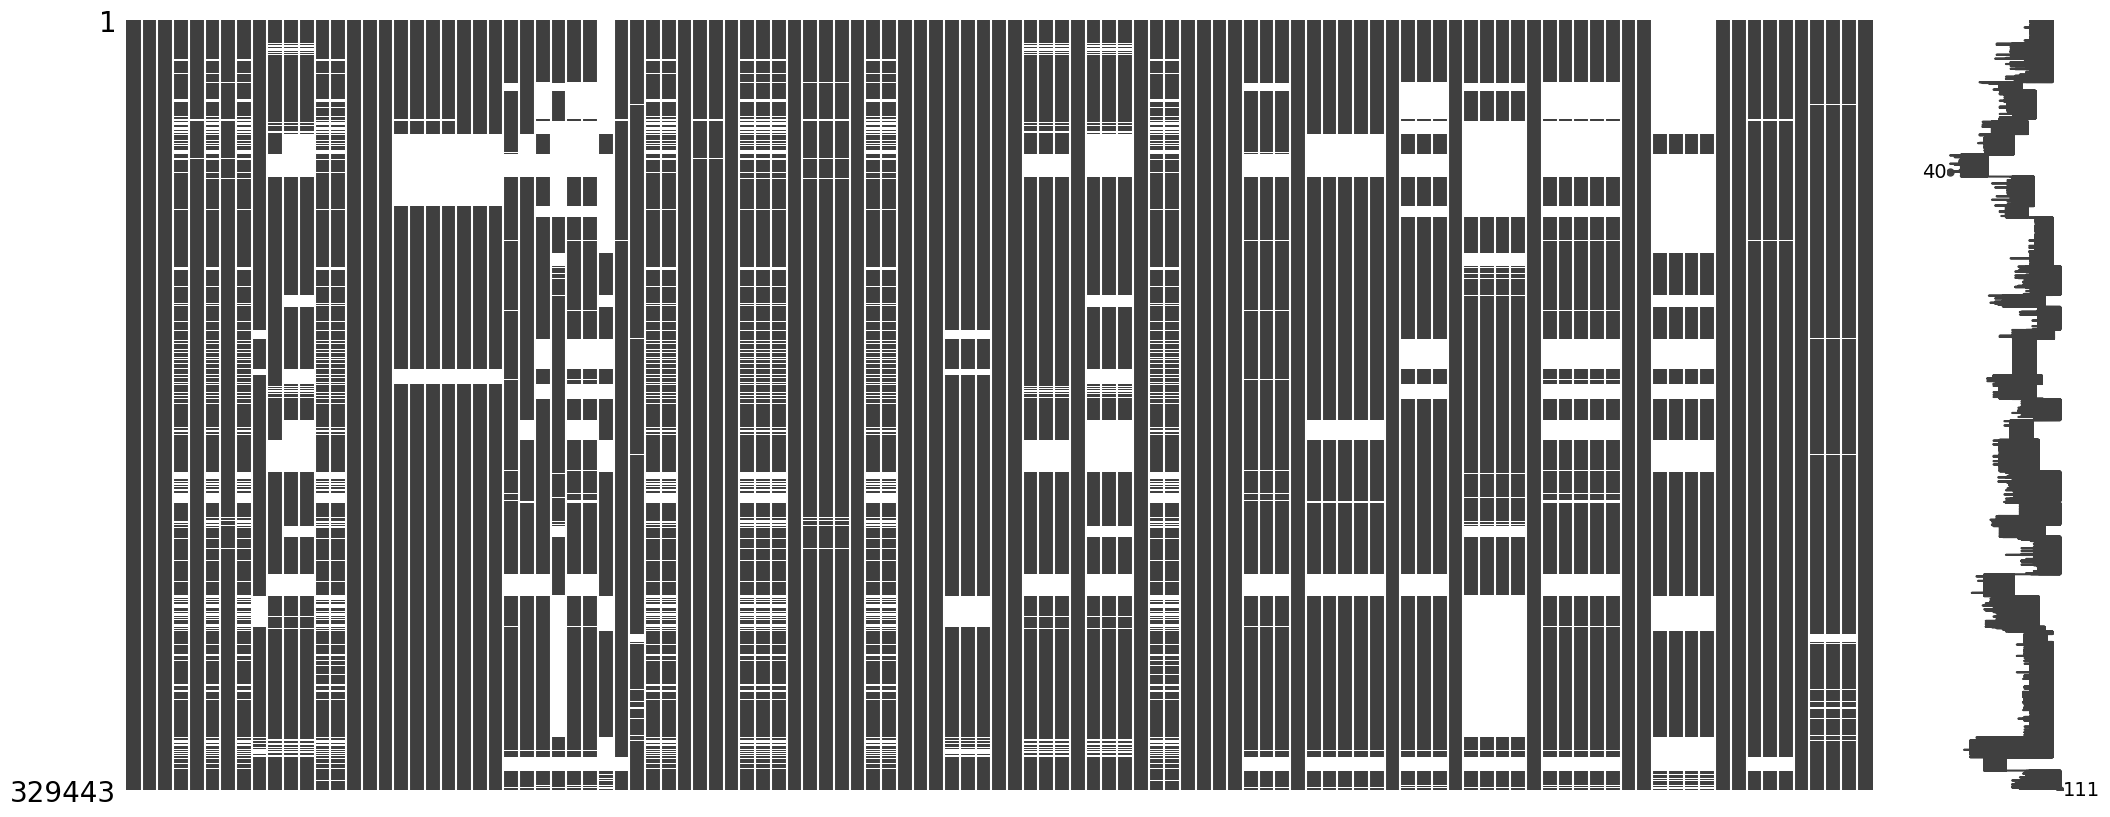

In [88]:
print("\nDataFrame before dropping variables:")
print(data.info())

# Drop dummy variables starting with specified names, except for those with exactly those names
dummy_prefixes = ['fcs_cat', 'hhs_cat', 'rcsi_cat', 'lcsi_cat', 'fsl_fc_phase', 'water_source', 'shelter_type']
exact_names = ['fcs_cat', 'hhs_cat', 'rcsi_cat', 'lcsi_cat', 'fsl_fc_phase', 'water_source', 'shelter_type']
pattern = '|'.join(f'^{prefix}(?!$)' for prefix in dummy_prefixes)  # Match prefixes but not exact names
columns_to_drop = data_select.filter(regex=pattern).columns
data_select = data_select.drop(columns=columns_to_drop)

# Drop non-predictive columns
data_select = data.drop(columns=['uuid', 'weight', "stratum", "fcs_cat", "hhs_cat", "rcsi_cat"])

print("\nDataFrame after dropping specified dummy variables:")
print(data_select.info())

# Identify variables with more than 50% missing values
missing_percentage = data_select.isnull().mean() * 100
columns_with_many_missing = missing_percentage[missing_percentage > 50].index.tolist()

print("\nColumns with more than 50% missing values:")
print(columns_with_many_missing)

# Show number of NAs and percentage for each of the identified variables
missing_data_summary = data_select[columns_with_many_missing].isnull().sum().to_frame(name='Number of NAs')
missing_data_summary['Percentage'] = missing_percentage[columns_with_many_missing]

print("\nMissing data summary for columns with more than 50% missing values:")
print(missing_data_summary)

# Assess missing data patterns
print("\nMissing data patterns:")

# Visualize missing data matrix
msno.matrix(data_select)
plt.show()

# Drop columns with over 50% NAs
data_select_na = data_select.drop(columns=columns_with_many_missing)

# Visualize missing data matrix
msno.matrix(data_select_na)
plt.show()

3.2 Change one-hot to label encoding for ordinal variables

In [89]:
# Load the new_labels CSV file
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])

print("\nLoaded new_labels DataFrame:")
print(new_labels.head())

# Create a copy of data_select_na to apply changes
data_ord = data_select_na.copy()

# Apply the label mapping to the data_ord DataFrame
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].fillna(pd.NA).astype('Int64')  # Fill NaNs with pd.NA before converting

# Check if recoded_variables are in data_ord
variables_in_data_ord = all(variable in data_ord.columns for variable in recoded_variables)
print(f"All recoded variables are in data_ord: {variables_in_data_ord}")

# Identify which variables are not in data_ord
missing_variables = [variable for variable in recoded_variables if variable not in data_ord.columns]
print(f"Variables not in data_ord: {missing_variables}")

# Display the first few rows of the recoded variables in the data_ord DataFrame
print("\nRecoded variables in data_ord DataFrame:")
print(data_ord[recoded_variables].head())

# Display the variable types of the recoded variables
print("\nVariable types of recoded variables:")
print(data_ord[recoded_variables].dtypes)


Loaded new_labels DataFrame:
       variable   label_old  label_new
0   hoh_age_cat       18_40          1
1   hoh_age_cat       41_59          2
2   hoh_age_cat     60_plus          3
3  shelter_type    adequate          1
4  shelter_type  inadequate          2


C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_16156\367835001.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_ord[variable] = data_ord[variable].replace(label_old, label_new)


All recoded variables are in data_ord: True
Variables not in data_ord: []

Recoded variables in data_ord DataFrame:
   hoh_age_cat  shelter_type  water_source  lcsi_cat  fsl_fc_phase
0            2             1             1         1             1
1            2             1             1         1             1
2            3             1             1         1             1
3            1             1             1         2             2
4            2             1             1         1             1

Variable types of recoded variables:
hoh_age_cat     Int64
shelter_type    Int64
water_source    Int64
lcsi_cat        Int64
fsl_fc_phase    Int64
dtype: object


3.3 One-hot encoding of msna, country, and year variables


In [90]:
# List of variables to one-hot encode
variables_to_encode = ['msna', 'country', 'year']

# Perform one-hot encoding with dtype set to int
data_encoded = pd.get_dummies(data_ord, columns=variables_to_encode, dtype=int)

# Extract the newly encoded variables
new_encoded_columns = [col for col in data_encoded.columns if any(var in col for var in variables_to_encode)]

# Display the first few rows of the newly encoded variables
print("\nNewly encoded variables in DataFrame:")
print(data_encoded[new_encoded_columns].head())


Newly encoded variables in DataFrame:
   msna_afg-2021  msna_afg-2022  msna_bfa-2021  msna_bfa-2022  msna_bfa-2023  \
0              1              0              0              0              0   
1              1              0              0              0              0   
2              1              0              0              0              0   
3              1              0              0              0              0   
4              1              0              0              0              0   

   msna_bgd-hosts-2023  msna_bgd-refugees-2023  msna_bgd_hc-2021  \
0                    0                       0                 0   
1                    0                       0                 0   
2                    0                       0                 0   
3                    0                       0                 0   
4                    0                       0                 0   

   msna_bgd_r-2021  msna_car-2021  ...  country_mmr  country_ner  count